今天我们来学习利用google的or-tools算法框架来求解路径规划问题，路径规划问题大体上可以分为两类，一类是TSP(Traveling Salesperson Problem),即旅行商问题，另一类是VRP(Vehicle Routing Problem)即车辆路径规划问题。一般来说VRP问题的复杂度要大于TSP, 也可以任务TSP是一个简化版的VRP,今天我们先讨论一下最简单的TSP问题，后续会对VRP问题进行深入研究。

## 什么是TSP

所谓旅行商问题(TSP)是指在地图上有若干个城市,有一个推销员(Salesperson)要去这些城市推销他的商品,推销员从其中一个城市出发，必须走遍规定的所有城市,最后返回出发地。我们的要求是使用最低的成本走遍所有的城市，所谓最低的成本是指走遍所有的城市所花的交通费最省,也可以是所走的路程最短，这里我们将后者作为最低成本，即求解走遍所有城市的最短路径。如下图所示的13个美国城市，推销员需要以最低的成本走遍这13个城市:

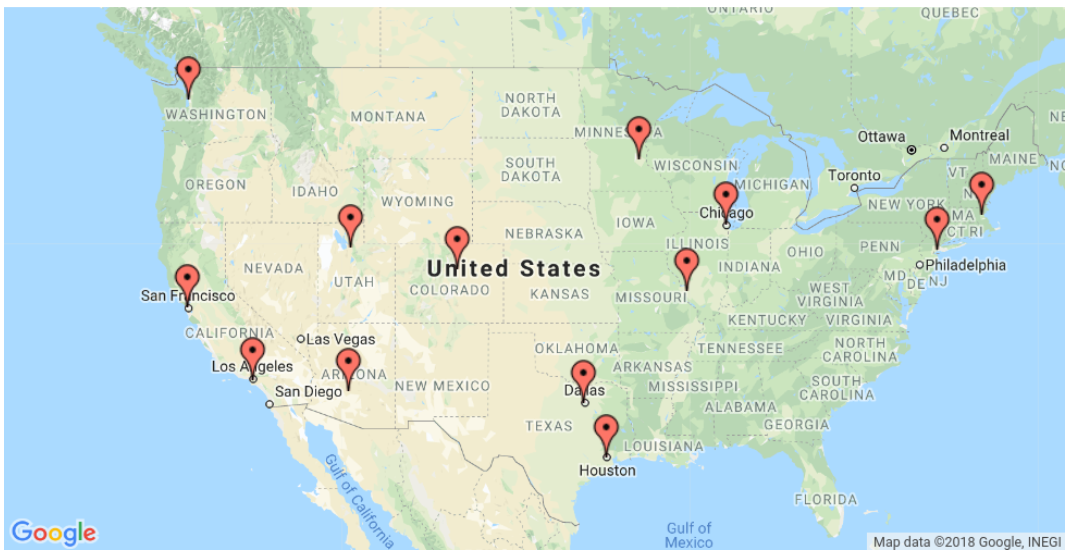



# 定义数据模型

这里我们定义了一个数据模型,数据模型中包含了各城市之间的距离矩阵(distance_matrix),车辆数量(num_vehicles),出发和返回点的索引(depot).其中：
* 距离矩阵(distance_matrix)是一个13×13的矩阵它表示13个城市两两之间的距离。 
* 车辆数量(num_vehicles)可以理解为旅行商开着一辆汽车要走遍这13个城市。 
* 出发和返回点(depot)表示出发和返回的城市索引，这里定义为0表示从第一个城市出发最后返回第一个城市。

In [7]:
import math
from ortools.constraint_solver import routing_enums_pb2,pywrapcp
import plotly.express as px

#定义数据模型
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = [
        [0, 2451, 713, 1018, 1631, 1374, 2408, 213, 2571, 875, 1420, 2145, 1972], 
        [2451, 0, 1745, 1524, 831, 1240, 959, 2596, 403, 1589, 1374, 357, 579],
        [713, 1745, 0, 355, 920, 803, 1737, 851, 1858, 262, 940, 1453, 1260],
        [1018, 1524, 355, 0, 700, 862, 1395, 1123, 1584, 466, 1056, 1280, 987],
        [1631, 831, 920, 700, 0, 663, 1021, 1769, 949, 796, 879, 586, 371],
        [1374, 1240, 803, 862, 663, 0, 1681, 1551, 1765, 547, 225, 887, 999],
        [2408, 959, 1737, 1395, 1021, 1681, 0, 2493, 678, 1724, 1891, 1114, 701],
        [213, 2596, 851, 1123, 1769, 1551, 2493, 0, 2699, 1038, 1605, 2300, 2099],
        [2571, 403, 1858, 1584, 949, 1765, 678, 2699, 0, 1744, 1645, 653, 600],
        [875, 1589, 262, 466, 796, 547, 1724, 1038, 1744, 0, 679, 1272, 1162],
        [1420, 1374, 940, 1056, 879, 225, 1891, 1605, 1645, 679, 0, 1017, 1200],
        [2145, 357, 1453, 1280, 586, 887, 1114, 2300, 653, 1272, 1017, 0, 504],
        [1972, 579, 1260, 987, 371, 999, 701, 2099, 600, 1162, 1200, 504, 0],
    ]  
    data['num_vehicles'] = 1 #汽车数量
    data['depot'] = 0 #起始和返回点
    return data

#创建数据模型
data = create_data_model()

# 创建路由模型

以下代码在程序的主要部分创建了索引管理器(manager)和路由模型(routing)。 manager主要根据distance_matrix来管理各个城市的索引，而routing用来计算和存储访问路径。

In [8]:
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'], data['depot'])
routing = pywrapcp.RoutingModel(manager)

# 创建距离回调函数

这里我们定义了一个距离回调函数用来从返回distance_matrix中返回给定的两个城市之间的距离，接下来我们还要设置旅行成本(routing.SetArcCostEvaluatorOfAllVehicles)它将告诉求解器如何计算任意两个城市之间的旅行成本—这里我们的成本指的是任意两个城市之间的距离。

In [9]:
def distance_callback(from_index, to_index):
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# 设置路径搜索策略

这是本算法最核心的功能,搜索策略指的是搜索最短路径使用的方法，这里将第一个解决方案策略(first_solution_strategy)设置为 PATH_CHEAPEST_ARC，它通过重复添加未访问节点的权重最小的边为求解器创建初始路径。

In [10]:
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

我们查看来一下 PATH_CHEAPEST_ARC策略在官方文档中的描述：

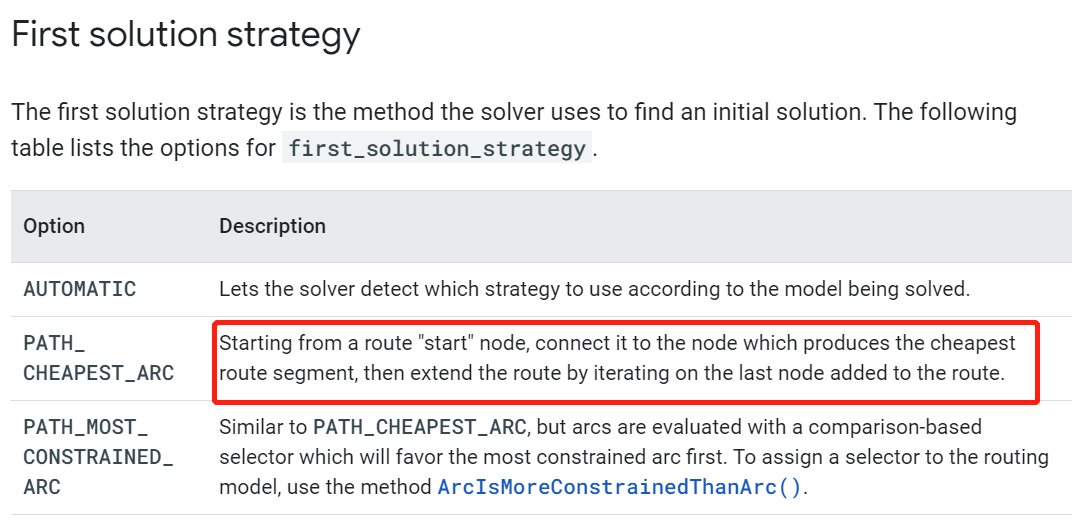

从路由“起始”节点开始，将其连接到产生成本最低的路由段的节点，然后通过迭代添加到路由的最后一个节点来扩展路由。

# 定义输出访问路径函数

print_solution函数输出访问路线及其距离。

In [11]:
def print_solution(manager, routing, solution):
    """Prints solution on console."""
    print('最短路程: {} 英里'.format(solution.ObjectiveValue()))
    index = routing.Start(0)
    plan_output = '访问路径:\n'
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += ' {} ->'.format(manager.IndexToNode(index))
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += ' {}\n'.format(manager.IndexToNode(index))
    print(plan_output)
    plan_output += 'Route distance: {}miles\n'.format(route_distance)

# 求解最短路径

我们调用routing.SolveWithParameters方法来快速求解最短路径,所使用的搜索策略是之前定义的 PATH_CHEAPEST_ARC,该策略可以快速得到一个可以接受的可行解,但不一定是最优解。

In [12]:
solution = routing.SolveWithParameters(search_parameters)
if solution:
    print_solution(manager, routing, solution)

最短路程: 7293 英里
访问路径:
 0 -> 7 -> 2 -> 3 -> 4 -> 12 -> 6 -> 8 -> 1 -> 11 -> 10 -> 5 -> 9 -> 0



# 结果分析

我们根据 PATH_CHEAPEST_ARC策略得到的最短路径来简单分析一下这个策略的实现原理,我们在距离矩阵(distance_matrix)上标上不同的颜色,红色表示已访问过的节点,绿色表示当前选中的节点,橙色表示路径最短的节点。我们来观察这个访问路径：  
0 -> 7 -> 2 -> 3 -> 4 -> 12 -> 6 -> 8 -> 1 -> 11 -> 10 -> 5 -> 9 -> 0

我们注意到节点0访问的是节点7(0->7),这里节点0到节点7的距离是213，它是矩阵第一行中的最小值。接下来节点7访问的是节点2(7 -> 2),节点7到节点2的距离是851，它也是节点7这一行中的最小值。再接下来节点2访问的是节点3(2->3),我们注意到节点2到节点3的距离是355，而这并非是节点2这一行中的最小值,最小值是到节点9的距离262才是最小值，以此类推我们发现搜索策略 PATH_CHEAPEST_ARC每次总是在最小值和次最小值之间做出选择，有时候选择最小值，有时候选择次最小值，比如节点3没有选择最短路径的节点9而是选择次最短路径的节点4，节点11也没有选择最短路径的节点5而是选择了次最短路径的节点10，这或许也是PATH_CHEAPEST_ARC为什么能比较快速的找到一个可行解的原因吧，因为它每次都是在最短或次最短的路径中搜索。


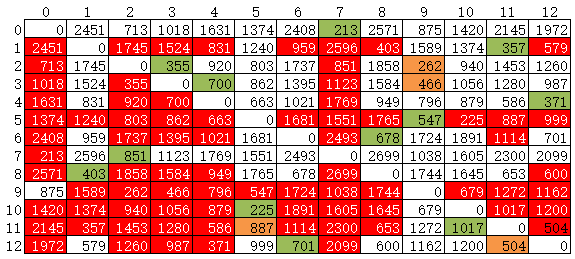

# 保存路径信息

通过下面的get_routes方法，我们可以把输出的路径信息保存起来，以供以后使用.

In [13]:
def get_routes(solution, routing, manager):
    routes = []
    for route_nbr in range(routing.vehicles()):
        index = routing.Start(route_nbr)
        route = [manager.IndexToNode(index)]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
        routes.append(route)
    return routes

routes = get_routes(solution, routing, manager)
for i, route in enumerate(routes):
      print('Route:',  route)

Route: [0, 7, 2, 3, 4, 12, 6, 8, 1, 11, 10, 5, 9, 0]


# 使用不同的搜索策略

下面将访问的城市数量拓展到280个,同时我们将比较两种不同的搜索策略,以及他们的性能和耗时，为了更加直观的展示路径信息，我们在数据模型中不在存储各个城市之间的距离矩阵,而是存储各个城市的地理坐标数组(可以理解为经纬度坐标)，同时还会定义一个计算距离矩阵的函数(compute_euclidean_distance_matrix),它使用欧式距离的方法根据地理坐标来计算任务两个城市之间的距离。其余方法函数和方法和上述方法一样，将不再一一说明。

下面的代码将首先使用 PATH_CHEAPEST_ARC 策略，并将最终所有的点和路径在一个二位平面中展示出来，这样可以更直观的看出访问的顺序和方向。

In [40]:
%%time
def create_data_model():
    data = {}
    # 定义地理坐标
    data['locations'] = [
        (288, 149), (288, 129), (270, 133), (256, 141), (256, 157), (246, 157),
        (236, 169), (228, 169), (228, 161), (220, 169), (212, 169), (204, 169),
        (196, 169), (188, 169), (196, 161), (188, 145), (172, 145), (164, 145),
        (156, 145), (148, 145), (140, 145), (148, 169), (164, 169), (172, 169),
        (156, 169), (140, 169), (132, 169), (124, 169), (116, 161), (104, 153),
        (104, 161), (104, 169), (90, 165), (80, 157), (64, 157), (64, 165),
        (56, 169), (56, 161), (56, 153), (56, 145), (56, 137), (56, 129),
        (56, 121), (40, 121), (40, 129), (40, 137), (40, 145), (40, 153),
        (40, 161), (40, 169), (32, 169), (32, 161), (32, 153), (32, 145),
        (32, 137), (32, 129), (32, 121), (32, 113), (40, 113), (56, 113),
        (56, 105), (48, 99), (40, 99), (32, 97), (32, 89), (24, 89),
        (16, 97), (16, 109), (8, 109), (8, 97), (8, 89), (8, 81),
        (8, 73), (8, 65), (8, 57), (16, 57), (8, 49), (8, 41),
        (24, 45), (32, 41), (32, 49), (32, 57), (32, 65), (32, 73),
        (32, 81), (40, 83), (40, 73), (40, 63), (40, 51), (44, 43),
        (44, 35), (44, 27), (32, 25), (24, 25), (16, 25), (16, 17),
        (24, 17), (32, 17), (44, 11), (56, 9), (56, 17), (56, 25),
        (56, 33), (56, 41), (64, 41), (72, 41), (72, 49), (56, 49),
        (48, 51), (56, 57), (56, 65), (48, 63), (48, 73), (56, 73),
        (56, 81), (48, 83), (56, 89), (56, 97), (104, 97), (104, 105),
        (104, 113), (104, 121), (104, 129), (104, 137), (104, 145), (116, 145),
        (124, 145), (132, 145), (132, 137), (140, 137), (148, 137), (156, 137),
        (164, 137), (172, 125), (172, 117), (172, 109), (172, 101), (172, 93),
        (172, 85), (180, 85), (180, 77), (180, 69), (180, 61), (180, 53),
        (172, 53), (172, 61), (172, 69), (172, 77), (164, 81), (148, 85),
        (124, 85), (124, 93), (124, 109), (124, 125), (124, 117), (124, 101),
        (104, 89), (104, 81), (104, 73), (104, 65), (104, 49), (104, 41),
        (104, 33), (104, 25), (104, 17), (92, 9), (80, 9), (72, 9),
        (64, 21), (72, 25), (80, 25), (80, 25), (80, 41), (88, 49),
        (104, 57), (124, 69), (124, 77), (132, 81), (140, 65), (132, 61),
        (124, 61), (124, 53), (124, 45), (124, 37), (124, 29), (132, 21),
        (124, 21), (120, 9), (128, 9), (136, 9), (148, 9), (162, 9),
        (156, 25), (172, 21), (180, 21), (180, 29), (172, 29), (172, 37),
        (172, 45), (180, 45), (180, 37), (188, 41), (196, 49), (204, 57),
        (212, 65), (220, 73), (228, 69), (228, 77), (236, 77), (236, 69),
        (236, 61), (228, 61), (228, 53), (236, 53), (236, 45), (228, 45),
        (228, 37), (236, 37), (236, 29), (228, 29), (228, 21), (236, 21),
        (252, 21), (260, 29), (260, 37), (260, 45), (260, 53), (260, 61),
        (260, 69), (260, 77), (276, 77), (276, 69), (276, 61), (276, 53),
        (284, 53), (284, 61), (284, 69), (284, 77), (284, 85), (284, 93),
        (284, 101), (288, 109), (280, 109), (276, 101), (276, 93), (276, 85),
        (268, 97), (260, 109), (252, 101), (260, 93), (260, 85), (236, 85),
        (228, 85), (228, 93), (236, 93), (236, 101), (228, 101), (228, 109),
        (228, 117), (228, 125), (220, 125), (212, 117), (204, 109), (196, 101),
        (188, 93), (180, 93), (180, 101), (180, 109), (180, 117), (180, 125),
        (196, 145), (204, 145), (212, 145), (220, 145), (228, 145), (236, 145),
        (246, 141), (252, 125), (260, 129), (280, 133)
    ]  
    data['num_vehicles'] = 1
    data['depot'] = 0
    return data

def compute_euclidean_distance_matrix(locations):
    """创建回调函数返回两个点之间的距离"""
    distances = {}
    for from_counter, from_node in enumerate(locations):
        distances[from_counter] = {}
        for to_counter, to_node in enumerate(locations):
            if from_counter == to_counter:
                distances[from_counter][to_counter] = 0
            else:
                # Euclidean distance
                distances[from_counter][to_counter] = (int(
                    math.hypot((from_node[0] - to_node[0]),
                               (from_node[1] - to_node[1]))))
    return distances

def print_solution(manager, routing, solution):
    """数据最终的访问路径"""
    print('最短路程: {}'.format(solution.ObjectiveValue()))
    index = routing.Start(0)
    plan_output = '访问路径:\n'
    route_distance = 0
    while not routing.IsEnd(index):
        #indexs.append(index)
        plan_output += ' {} ->'.format(manager.IndexToNode(index))
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += ' {}\n'.format(manager.IndexToNode(index))
    print(plan_output)
    plan_output += 'Objective: {}m\n'.format(route_distance)

# 创建数据模型
data = create_data_model()

# 创建索引管理器(manager)和路由模型(routing)
manager = pywrapcp.RoutingIndexManager(len(data['locations']),
                                       data['num_vehicles'], data['depot'])
routing = pywrapcp.RoutingModel(manager)
#计算距离矩阵
distance_matrix = compute_euclidean_distance_matrix(data['locations'])

#定义回调函数
def distance_callback(from_index, to_index):
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return distance_matrix[from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

#定义并设置搜索策略,这里使用：PATH_CHEAPEST_ARC
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

#引导式局部搜索策略
# search_parameters.local_search_metaheuristic = (
#     routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
# search_parameters.time_limit.seconds = 30
# search_parameters.log_search = True

# 求解
solution = routing.SolveWithParameters(search_parameters)

# 输出访问路径
if solution:
    routes = get_routes(solution, routing, manager)    
    print_solution(manager, routing, solution)
    x = [data['locations'][i][0] for i in routes[0]]
    y = [data['locations'][i][1] for i in routes[0]]
    x.append(x[0])
    y.append(y[0])
    fig = px.line(x=x, y=y,markers=True)
    fig.show()


最短路程: 2790
访问路径:
 0 -> 1 -> 279 -> 2 -> 278 -> 277 -> 248 -> 247 -> 243 -> 242 -> 241 -> 240 -> 239 -> 238 -> 245 -> 244 -> 246 -> 249 -> 250 -> 229 -> 228 -> 231 -> 230 -> 237 -> 236 -> 235 -> 234 -> 233 -> 232 -> 227 -> 226 -> 225 -> 224 -> 223 -> 222 -> 218 -> 221 -> 220 -> 219 -> 202 -> 203 -> 204 -> 205 -> 207 -> 206 -> 211 -> 212 -> 215 -> 216 -> 217 -> 214 -> 213 -> 210 -> 209 -> 208 -> 251 -> 254 -> 255 -> 257 -> 256 -> 253 -> 252 -> 139 -> 140 -> 141 -> 142 -> 143 -> 199 -> 201 -> 200 -> 195 -> 194 -> 193 -> 191 -> 190 -> 189 -> 188 -> 187 -> 163 -> 164 -> 165 -> 166 -> 167 -> 168 -> 169 -> 171 -> 170 -> 172 -> 105 -> 106 -> 104 -> 103 -> 107 -> 109 -> 110 -> 113 -> 114 -> 116 -> 117 -> 61 -> 62 -> 63 -> 65 -> 64 -> 84 -> 85 -> 115 -> 112 -> 86 -> 83 -> 82 -> 87 -> 111 -> 108 -> 89 -> 90 -> 91 -> 102 -> 101 -> 100 -> 99 -> 98 -> 97 -> 96 -> 95 -> 94 -> 93 -> 92 -> 79 -> 88 -> 81 -> 80 -> 78 -> 77 -> 76 -> 74 -> 75 -> 73 -> 72 -> 71 -> 70 -> 69 -> 66 -> 68 -> 67 -> 57 -> 56 -> 

CPU times: user 1.58 s, sys: 1 ms, total: 1.58 s
Wall time: 1.58 s


这里我们使用的搜索策略任然是PATH_CHEAPEST_ARC，我们得到的最短路程是2790，访问的起始点位于上图的右上角坐标是(288,149)并沿箭头方法依次访问所有节点,最后回到起始点。


# 改变搜索策略

路由求解器并不总是将最优解返回给 TSP，因为路由问题在计算上是相当复杂并难以计算。 例如，上一个示例中返回的解决方案不是最佳路线。 要找到更好的解决方案，可以使用更高级的搜索策略，称为引导式局部搜索，它使求解器能够避开局部最小值-一种比所有附近路线都短的解决方案，但不是全局最小值。 远离局部最小值后，求解器继续搜索。

In [38]:
%%time
ObjectiveValues={}
X={}
Y={}
for i in range(50):
    i+=1
    t=i*15
    #print(i,t,datetime.datetime.now())
    data = create_data_model()
    manager = pywrapcp.RoutingIndexManager(len(data['locations']),data['num_vehicles'], data['depot'])
    routing = pywrapcp.RoutingModel(manager)
    
    distance_matrix = compute_euclidean_distance_matrix(data['locations'])
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    
    search_parameters.time_limit.seconds = t
    search_parameters.log_search = True
    solution = routing.SolveWithParameters(search_parameters)
    
    if solution:
        routes = get_routes(solution, routing, manager)
        v = solution.ObjectiveValue()
        ObjectiveValues[t]=v
        x = [data['locations'][i][0] for i in routes[0]]        
        y = [data['locations'][i][1] for i in routes[0]]
        x.append(x[0])
        y.append(y[0])
        X[t]=x
        Y[t]=y


fig = px.line(x=ObjectiveValues.keys(), 
              y=ObjectiveValues.values(),
              labels={'y':'最短路程', 'x':'time_limit'},
              markers=True)
fig.show()

CPU times: user 111 ms, sys: 3 ms, total: 114 ms
Wall time: 110 ms


我们发现随着搜索时间的逐步延长，最短路程由原来的2672逐步减少到最后的2565，并且当搜索时间延长到435秒以后,最短路程稳定在2565不再变化,算法趋于收敛。

下面我们观察一下在time_limit分别等于15,135,240,480时的访问路径的情况：

In [35]:
fig = px.line(x=X[15], y=Y[15],markers=True)
fig.update_layout(title_text="time_limit=15秒,最短路程={}".format(ObjectiveValues[15]), title_x=0.5)
fig.show()

In [34]:
fig = px.line(x=X[135], y=Y[135],markers=True)
fig.update_layout(title_text="time_limit=135秒,最短路程={}".format(ObjectiveValues[135]), title_x=0.5)
fig.show()

In [33]:
fig = px.line(x=X[240], y=Y[240],markers=True)
fig.update_layout(title_text="time_limit=240秒,最短路程={}".format(ObjectiveValues[240]), title_x=0.5)
fig.show()

In [32]:
fig = px.line(x=X[480], y=Y[480],markers=True)
fig.update_layout(title_text="time_limit=480秒,最短路程={}".format(ObjectiveValues[480]), title_x=0.5)
fig.show()

 综上所述,当我们将搜索策略从原来的FirstSolutionStrategy.PATH_CHEAPEST_ARC改变成LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH后,最短路程由原来的2790变成了2565，但我们也耗费了更多的时间来求解，凡事有利有弊，有时候全局最优解可能会难以获得，而在短时间内获得一个局部最优解也是一个不错的选择。